## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:

# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.001, 0.0001]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=reduce_factor, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 

Epoch 25/25
50000/50000 [==============================] - 18s 361us/step - loss: 0.9501 - acc: 0.6819 - val_loss: 1.4701 - val_acc: 0.4940

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.001.
Numbers of exp: 1, reduce_factor: 0.00, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
__________

Epoch 10/25
50000/50000 [==============================] - 19s 373us/step - loss: 1.2918 - acc: 0.5527 - val_loss: 1.5003 - val_acc: 0.4698
Epoch 11/25
50000/50000 [==============================] - 17s 349us/step - loss: 1.2633 - acc: 0.5600 - val_loss: 1.4904 - val_acc: 0.4724
Epoch 12/25
50000/50000 [==============================] - 21s 411us/step - loss: 1.2355 - acc: 0.5713 - val_loss: 1.4835 - val_acc: 0.4738
Epoch 13/25
50000/50000 [==============================] - 19s 380us/step - loss: 1.2090 - acc: 0.5812 - val_loss: 1.4759 - val_acc: 0.4765
Epoch 14/25
50000/50000 [==============================] - 23s 457us/step - loss: 1.1838 - acc: 0.5907 - val_loss: 1.4721 - val_acc: 0.4835
Epoch 15/25
50000/50000 [==============================] - 20s 398us/step - loss: 1.1588 - acc: 0.6013 - val_loss: 1.4691 - val_acc: 0.4815
Epoch 16/25
50000/50000 [==============================] - 21s 413us/step - loss: 1.1347 - acc: 0.6079 - val_loss: 1.4642 - val_acc: 0.4865
Epoch 17/25
50000/50

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 21s 422us/step - loss: 1.7560 - acc: 0.3902 - val_loss: 1.5814 - val_acc: 0.4514
Epoch 2/25
50000/50000 [==============================] - 19s 390us/step - loss: 1.4279 - acc: 0.4964 - val_loss: 1.4589 - val_acc: 0.4809
Epoch 3/25
50000/50000 [==============================] - 18s 368us/step - loss: 1.2959 - acc: 0.5428 - val_loss: 1.4270 - val_acc: 0.4994
Epoch 4/25
50000/50000 [==============================] - 19s 385us/step - loss: 1.1936 - acc: 0.5797 - val_loss: 1.4085 - val_acc: 0.5033
Epoch 5/25
50000/50000 [==============================] - 19s 376us/step - loss: 1.1040 - acc: 0.6149 - val_loss: 1.4075 - val_acc: 0.5092
Epoch 6/25
50000/50000 [==============================] - 20s 398us/step - loss: 1.0248 - acc: 0.6414 - val_loss: 1.3968 - val_acc: 0.5168
Epoch 7/25
50000/50000 [==============================] - 19s 388us/step - loss: 0.9478 - acc: 0.6701 - val_loss: 1.

Epoch 21/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.3627 - acc: 0.8802 - val_loss: 1.9175 - val_acc: 0.5225
Epoch 22/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.3326 - acc: 0.8894 - val_loss: 2.0085 - val_acc: 0.5116
Epoch 23/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.2974 - acc: 0.9025 - val_loss: 2.0676 - val_acc: 0.5189
Epoch 24/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.2600 - acc: 0.9162 - val_loss: 2.1573 - val_acc: 0.5083
Epoch 25/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.2356 - acc: 0.9252 - val_loss: 2.2219 - val_acc: 0.5174
Numbers of exp: 6, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________

Epoch 5/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.1511 - acc: 0.6017 - val_loss: 1.3870 - val_acc: 0.5148
Epoch 6/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.0841 - acc: 0.6265 - val_loss: 1.3863 - val_acc: 0.5174
Epoch 7/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.0275 - acc: 0.6454 - val_loss: 1.3741 - val_acc: 0.5176
Epoch 8/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.9711 - acc: 0.6681 - val_loss: 1.3726 - val_acc: 0.5179
Epoch 9/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.9228 - acc: 0.6881 - val_loss: 1.3786 - val_acc: 0.5155
Epoch 10/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.8736 - acc: 0.7059 - val_loss: 1.3834 - val_acc: 0.5205
Epoch 11/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.8296 - acc: 0.7233 - val_loss: 1.3977 - val_acc: 0.5161
Epoch 12/25
50000/50000 [=======

50000/50000 [==============================] - 6s 125us/step - loss: 0.3045 - acc: 0.9003 - val_loss: 2.0974 - val_acc: 0.5123
Numbers of exp: 9, reduce_factor: 0.00, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_38 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_39

50000/50000 [==============================] - 6s 122us/step - loss: 0.8458 - acc: 0.7055 - val_loss: 1.4418 - val_acc: 0.5220
Epoch 11/25
50000/50000 [==============================] - 6s 125us/step - loss: 0.7936 - acc: 0.7258 - val_loss: 1.5655 - val_acc: 0.4955
Epoch 12/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.7452 - acc: 0.7430 - val_loss: 1.5226 - val_acc: 0.5114
Epoch 13/25
50000/50000 [==============================] - 6s 124us/step - loss: 0.6930 - acc: 0.7627 - val_loss: 1.5654 - val_acc: 0.5220

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 14/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.5100 - acc: 0.8400 - val_loss: 1.4540 - val_acc: 0.5374
Epoch 15/25
50000/50000 [==============================] - 6s 122us/step - loss: 0.4596 - acc: 0.8577 - val_loss: 1.5042 - val_acc: 0.5317
Epoch 16/25
50000/50000 [==============================] - 6s 125us/step - loss: 0.4168 - acc: 0.

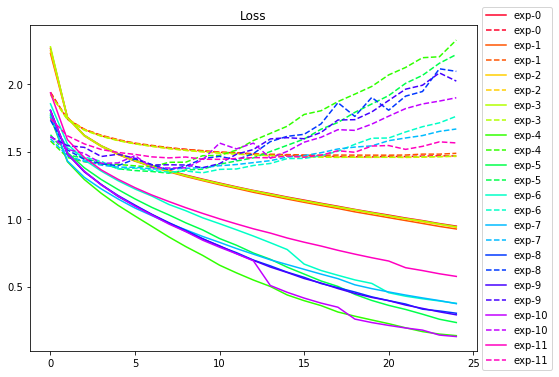

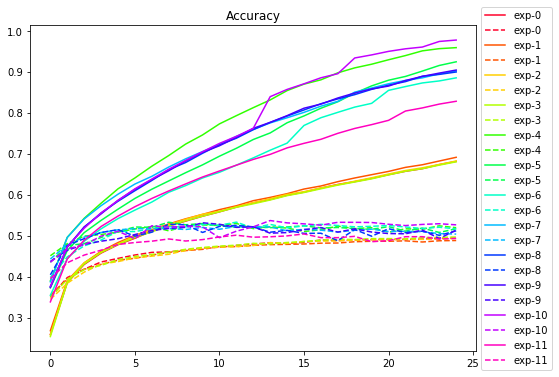

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()